In [1]:
%load_ext jbmagics
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2

Exception reporting mode: Minimal


# Example: Head Controlled Well

This example demonstrates how `pymf6` can be used to control the rate of an
extraction well so that the well water level does fall below under a given water
level.

## Setting up a model with `flopy`

First, we create a simple model with `flopy`.
You may use any GUI tool such as ModelMuse to create such a model.
This is not specific to `pymf6` but helps to better understand the problem.
You may skip ahead to the section with use of `pymf6`.

### Creating the input data

First, we import a few need libraries:

In [2]:
%%include ../../../src/pymf6/modeling_tools/make_model.py
end_before = 'def'
import_module = True

```python
"""Create and run a MODFLOW 6 model with flopy.
"""

import flopy

import pymf6

MF6EXE = pymf6.__mf6_exe__
```


The function `make_input` creates our model with help pf `flopy`:

In [3]:
%%include ../../../src/pymf6/modeling_tools/make_model.py
start_at = 'def _make_wel_stress_period'
end_at = 'sim.write_simulation()'
import_module = True

```python
"""Create and run a MODFLOW 6 model with flopy.
"""

import flopy

import pymf6

MF6EXE = pymf6.__mf6_exe__


def make_input(
        model_data,
        exe_name=MF6EXE,
        verbosity_level=0):
    """Create MODFLOW 6 input"""
    sim = flopy.mf6.MFSimulation(
        sim_name=model_data['name'],
        sim_ws=model_data['model_path'],
        exe_name=exe_name,
        verbosity_level=verbosity_level,
    )
    times = model_data['times']
    repeat_times = model_data['repeat_times']
    tdis_rc = [(1.0, 1, 1.0)] + [times] * repeat_times
    flopy.mf6.ModflowTdis(
        sim, pname="tdis",
        time_units=model_data['time_units'],
        nper=repeat_times + 1,
        perioddata=tdis_rc,
    )
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=model_data['name'],
        save_flows=True)
    dim_kwargs = {name: model_data[name] for name in
              ['nrow', 'ncol', 'nlay', 'delr', 'delc', 'top', 'botm']
              }
    model_data['dim_kwargs'] = dim_kwargs
    flopy.mf6.ModflowGwfdis(gwf, **dim_kwargs)
    flopy.mf6.ModflowGwfic(gwf)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        save_specific_discharge=True,
        icelltype=[0],
        k=model_data['k'],
        k33=model_data['k33'],
    )
    sy = flopy.mf6.ModflowGwfsto.sy.empty(
        gwf,
        default_value=model_data['sy']
    )
    ss = flopy.mf6.ModflowGwfsto.ss.empty(
        gwf, default_value=model_data['ss']
    )
    flopy.mf6.ModflowGwfsto(
        gwf,
        pname="sto",
        save_flows=True,
        iconvert=1,
        ss=ss,
        sy=sy,
        steady_state={0: True},
        transient={index: True for index in range(1, len(times))},
        )

    stress_period_data = {}
    for index in range(len(times)):
        entry = []
        for well in model_data['wells'].values():
            value = [well['coords'], well['q'][index]]
            if model_data['transport']:
                value.append(0)
            entry.append(tuple(value))
        stress_period_data[index + 1] = entry
    wel_kwargs= {}
    if model_data['transport']:
        wel_kwargs.update({
            'auxiliary': 'CONCENTRATION',
            'pname': 'WEL-1'})
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=stress_period_data,
        **wel_kwargs,
    )
    chd_kwargs= {}
    if model_data['transport']:
        chd_kwargs.update({
            'auxiliary': 'CONCENTRATION',
            'pname': 'CHD-1'})
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=model_data['chd'],
        **chd_kwargs
    )
    budget_file = model_data['name'] + '.bud'
    head_file = model_data['name'] + '.hds'
    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=budget_file,
        head_filerecord=head_file,
        saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

    if model_data['transport']:
        make_transport_model(sim, model_data)

    sim.write_simulation()


def make_transport_model(sim, model_data):

    # Instantiating MODFLOW 6 groundwater transport package
    gwtname = 'gwt_' + model_data['name']
    gwt = flopy.mf6.MFModel(
        sim,
        model_type='gwt6',
        modelname=gwtname,
        model_nam_file=f'{gwtname}.nam'
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        # outer_dvclose=hclose,
        # outer_maximum=nouter,
        under_relaxation="NONE",
        # inner_maximum=ninner,
        # inner_dvclose=hclose,
        # rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        # relaxation_factor=relax,
        filename=f'{gwtname}.ims'
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        **model_data['dim_kwargs'],
        filename=f'{gwtname}.dis'
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(
        gwt, strt=model_data['initial_concentration'], filename=f'{gwtname}.ic'
    )

    # Instantiating MODFLOW 6 transport advection package
    flopy.mf6.ModflowGwtadv(
        gwt, scheme=model_data['scheme'], filename=f'{gwtname}.adv'
    )

    # Instantiating MODFLOW 6 transport dispersion package
    long_disp = model_data['longitudinal_dispersivity']
    ratio = model_data['dispersivity_ratio']
    if long_disp != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            xt3d_off=True,
            alh=long_disp,
            ath1=long_disp * ratio,
            filename=f'{gwtname}.dsp'
        )

    # Instantiating MODFLOW 6 transport mass storage package (formerly "reaction" package in MT3DMS)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=model_data['porosity'],
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption=None,
        bulk_density=None,
        distcoef=None,
        filename=f'{gwtname}.mst'
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [
        ('WEL-1', 'AUX', 'CONCENTRATION'),
        ('CHD-1', 'AUX', 'CONCENTRATION')
        ]
    flopy.mf6.ModflowGwtssm(
        gwt, sources=sourcerecarray, filename=f'{gwtname}.ssm'
    )
    if 'cnc' in model_data:
        flopy.mf6.ModflowGwtcnc(
            gwt,
            stress_period_data=model_data['cnc']
        )
    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f'{gwtname}.cbc',
        concentration_filerecord=f'{gwtname}.ucn',
        concentrationprintrecord=[
            ('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')
        ],
        saverecord=[('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')],
        printrecord=[('CONCENTRATION', 'LAST'), ('BUDGET', 'LAST')],
    )

    # Instantiate observation package (for transport)
    obs = model_data['obs']
    if obs:
        obslist = []
        for name, obs_coords in obs:
            obslist.append([name, 'concentration', obs_coords])
        obsdict = {f'{gwtname}.obs.csv': obslist}
        flopy.mf6.ModflowUtlobs(
            gwt, print_input=False, continuous=obsdict
        )

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(
        sim,
        exgtype='GWF6-GWT6',
        exgmnamea=model_data['name'],
        exgmnameb=gwtname,
        filename=f'{model_data["name"]}.gwfgwt'
    )

def get_simulation(model_path, exe_name=MF6EXE, verbosity_level=0):
    """Get simulation for a model."""
    sim = flopy.mf6.MFSimulation.load(
        sim_ws=model_path,
        exe_name=exe_name,
        verbosity_level=verbosity_level,
    )
    return sim


def run_simulation(model_path, verbosity_level=0):
    """Run a MODFLOW 6 model"""
    sim = get_simulation(
        model_path,
        verbosity_level=verbosity_level)
    sim.run_simulation()
```


We specify some data for the model with a dictionary.
Only a few features `flopy` supplies are supported:

In [4]:
%%include ../../../src/pymf6/modeling_tools/base_model.py
end_before  = 'BASE_MODEL_DATA'
import_module = True 

```python
"""Base model data.

Data for a basic flow model build with `flopy`.
Changing the data allows to quickly create a modified model.
Note: Not all packages are supported, yet.

Assumptions:

1. The first stress period is steady state.
2. Currently, only CHD boundary conditions are supported.
3. For all not supplied values `flopy` default values will be used.
"""


import sys
```


This is our base model:

In [5]:
%%include ../../../src/pymf6/modeling_tools/base_model.py
start_at  = 'BASE_MODEL_DATA'
end_before = 'def make_model_data'
import_module = True 

```python
BASE_MODEL_DATA = {
    'wells': {
        'wel_out': {'q': (-0.05, -0.5, -0.05), 'coords': (0, 4, 4)},
              },
    #  flopy.mf6.ModflowTdis
    'times': (
        10.0,  # perlen (double) is the length of a stress period.
        120,   # nstp (integer) is the number of time steps in a stress period.
        1.0,   # tsmult (double) is the multiplier for the length of successive
               # time steps.
    ),
    'time_units': "DAYS",
    'repeat_times': 3,  # nper = repeat_times + 1
    #  flopy.mf6.ModflowGwfdis
    'nrow': 10,
    'ncol': 10,
    'nlay': 1,
    'delr': 1.0,
    'delc': 1.0,
    'top': 1.0,
    'botm': 0.0,
    #  flopy.mf6.ModflowGwfnpf
    'k': [0.5],  # initial value of k
    'k33': [0.1],  # vertical anisotropy
    #  flopy.mf6.ModflowGwfsto
    'sy': 0.2,
    'ss': 0.000001,
    # flopy.mf6.ModflowGwfchd(
    'chd': [
        [(0, 0, 0), 1.],
        [(0, 9, 9), 1.]
    ],
    'cnc': [
        [(0, 5, 1), 0.],
    ],
    'transport': False,
}

BASE_TRANSPORT_MODEL_DATA = {
    'initial_concentration': 0,
    'scheme': 'UPSTREAM', #'TVD',  # or 'UPSTREAM'
    'longitudinal_dispersivity': 1.0,
    # Ratio of transverse to longitudinal dispersitivity
    'dispersivity_ratio': 1.0,
    'porosity': 0.35,
    'obs': None,
}
```


A helper functions updates the base data with data for our current,
specific model:

In [6]:
%%include ../../../src/pymf6/modeling_tools/base_model.py
start_at  = 'def make_model_data'
import_module = True 

```python
def make_model_data(
        specific_model_data,
        base_model_data=BASE_MODEL_DATA,
        base_transport_model_data=BASE_TRANSPORT_MODEL_DATA):
    """Make model data.

    specific_model_data - dictionary with data specific for the current model
                          will merged with `base_model_data`
                          existing keys in `base_model_data` will be overridden
    base_model_data - dictionary with basic model data defaults to
                      `BASE_MODEL_DATA`
    """
    if specific_model_data.get('transport'):
        base_model_data.update(base_transport_model_data)
    # old way up to Python 3.8
    if sys.version_info[:2] < (3, 9):
        return {**base_model_data, **specific_model_data}
    # new way starting from Python 3.9
    return base_model_data | specific_model_data
```


This is specific:

In [7]:
model_path = 'models/mf6'
name = 'headconwell'

specific_model_data = {
    'model_path': model_path,
    'name': name,
}

model_data = make_model_data(specific_model_data)

Now, we create the input files

In [8]:
%xmode context

Exception reporting mode: Context


In [9]:
make_input(model_data)

### Running the model

The function `get_simulation` retrieves a `flopy` simulation object:

In [10]:
%%include ../../../src/pymf6/modeling_tools/make_model.py
start_at = 'def get_simulation'
end_at = 'return'
import_module = True

```python
def get_simulation(model_path, exe_name=MF6EXE, verbosity_level=0):
    """Get simulation for a model."""
    sim = flopy.mf6.MFSimulation.load(
        sim_ws=model_path,
        exe_name=exe_name,
        verbosity_level=verbosity_level,
    )
    return sim
```


This function runs the model:

In [11]:
%%include ../../../src/pymf6/modeling_tools/make_model.py
start_at = 'def run_simulation'
end_at = 'sim.run_simulation()'
import_module = True

```python
def run_simulation(model_path, verbosity_level=0):
    """Run a MODFLOW 6 model"""
    sim = get_simulation(
        model_path,
        verbosity_level=verbosity_level)
    sim.run_simulation()
```


We run the simulation:

In [12]:
run_simulation(model_path=model_path)

There is visible output from MODFLOW 6.
Setting the `verbosity_level` to `1` or higher in `run_simulation` will show
the simulations steps.

### Looking at the model results

Let's look at the model results.
This function visualizes the head at the end of the last time step: 

In [13]:
%%include ../../../src/pymf6/modeling_tools/plotting.py
import_module = True

```python
"""Plot model results.
"""

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import flopy
from flopy.utils.postprocessing import get_specific_discharge

from pymf6.modeling_tools. make_model import get_simulation


def show_heads(
        model_path,
        name,
        title='',
        show_grid=True,
        show_wells=True):
    """Plot calculated heads along with flow vector."""
    sim = get_simulation(model_path, name)
    gwf = sim.get_model(name)

    head = gwf.output.head().get_data(kstpkper=(119, 2))
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[240]
    qx, qy, _ = get_specific_discharge(spdis, gwf)
    pmv = flopy.plot.PlotMapView(gwf)
    levels=np.arange(0.2, 1.4, 0.02)
    arr = pmv.plot_array(head)
    if show_grid:
        pmv.plot_grid(colors='white')
    pmv.contour_array(
        head,
        levels=levels,
    )
    if show_wells:
        pmv.plot_bc(name='wel', plotAll=True, kper=1)
    plot = pmv.plot_vector(
        qx,
        qy,
        normalize=True,
        color="white")
    plot.axes.set_xlabel('x (m)')
    plot.axes.set_ylabel('y (m)')
    plot.axes.set_title(title)
    #ticks = np.arange(0, 1.41, 0.1)
    cbar = plot.get_figure().colorbar(arr) # ticks=ticks)
    cbar.set_label('Groundwater level (m)')
    return plot


def show_bcs(
        model_path,
        name,
        title='Boundary Conditions',
        bc_names = ('chd', 'wel'),
        show_grid=True):
    """Show location of boundary conditions."""
    handles = []
    sim = get_simulation(model_path, name)
    gwf = sim.get_model(name)
    pmv = flopy.plot.PlotMapView(gwf)

    def add_bc(name, handles=handles, pmv=pmv):
        """Add a BC including legend entry"""
        name = name.upper()
        bc = pmv.plot_bc(name=name, plotAll=True, kper=1)
        color = bc.cmap.colors[-1]
        handles.append(Patch(facecolor=color, edgecolor='k', label=name))
        return bc
    for bc_name in bc_names:
        plot = add_bc(bc_name)
    if show_grid:
        pmv.plot_grid()
    plot.axes.set_title(title)
    plot.axes.legend(handles=handles, loc=(1.2, 0))
    return plot

def show_concentration(
        model_path, name,
        title='',
        show_grid=True,
        levels=None,
        kstpkper=None,
        show_wells=True,
        vmin=None,
        vmax=None,
        show_contours=True,
        show_arrows=False,):
    """Plot calculated heads along with flow vector."""
    gwtname = 'gwt_' + name
    sim = get_simulation(model_path, name)
    gwt = sim.get_model(gwtname)

    conc = gwt.output.concentration().get_data(kstpkper)
    pmv = flopy.plot.PlotMapView(gwt)
    arr = pmv.plot_array(conc, vmin=vmin, vmax=vmax)
    if show_grid:
        pmv.plot_grid(colors='white')
    if show_wells:
        flow_sim = get_simulation(model_path, name)
        gwf = flow_sim.get_model(name)
        plot = pmv.plot_bc(package=gwf.get_package('wel'), plotAll=True, kper=1)
    if show_contours:
        pmv.contour_array(
            conc,
            levels=levels,
        )
    plot.axes.set_xlabel('x (m)')
    plot.axes.set_ylabel('y (m)')
    plot.axes.set_title(title)
    cbar = arr.get_figure().colorbar(arr, ticks=levels)
    cbar.set_label('Concentration')
    if show_arrows:
        gwf = sim.get_model(name)
        bud = gwf.output.budget()
        spdis = bud.get_data(text='DATA-SPDIS')[240]
        qx, qy, _ = get_specific_discharge(spdis, gwf)
        plot = pmv.plot_vector(
            qx,
            qy,
            normalize=True,
            color="white")
    return plot


def show_well_head(
        wel_coords,
        model_data,
        title='',
        y_start=0.3,
        y_end=1.05,
        upper_head_limit=None,
        lower_head_limit=None,
        x=(0, 32)):
    """Plot head at well over time."""
    sim = get_simulation(model_data['model_path'], model_data['name'])
    gwf = sim.get_model(model_data['name'])
    print(gwf.output)
    heads = gwf.output.head().get_ts(wel_coords)
    _, ax = plt.subplots()
    ax.plot(heads[:, 0], heads[:, 1], label='Well water level')
    ax.set_xlabel('Time (d)')
    ax.set_ylabel('Groundwater level (m)')
    y_stress = (y_start, y_end)
    x_stress_1 = (1, 1)
    times = model_data['times']
    times_diff = times[0]
    x_stresses = []
    for count in range(1, len(times)):
        start = count * times_diff + 1
        x_stresses.append((start, start))
        x_stresses.append(y_stress)
    ax.set_xlim(*x)
    ax.set_ylim(y_start, y_end)
    ax.set_title(title)
    limit_range = False
    one_limit = False
    text = 'Target water level'
    if (lower_head_limit is not None) and (upper_head_limit is not None):
        limit_range = True
        text += ' range'
        y1 = [lower_head_limit] * 2
        y2 =[upper_head_limit] * 2
    elif lower_head_limit is not None:
        one_limit = True
        y1 = [lower_head_limit] * 2
    elif upper_head_limit is not None:
        one_limit = True
        y1 = [upper_head_limit] * 2
    if one_limit or limit_range:
        ax.plot(x, y1, color='red', linestyle=':',
                label=text)
    if limit_range:
        ax.plot(x, y2, color='red', linestyle=':')
    ax.plot(
         x_stress_1, y_stress,
         color='lightblue', linestyle=':', label='Stress periods')
    ax.plot(
         *x_stresses,
         color='lightblue', linestyle=':')
    ax.legend(loc=(1.1, 0))
    return ax
```


We look at the heads:

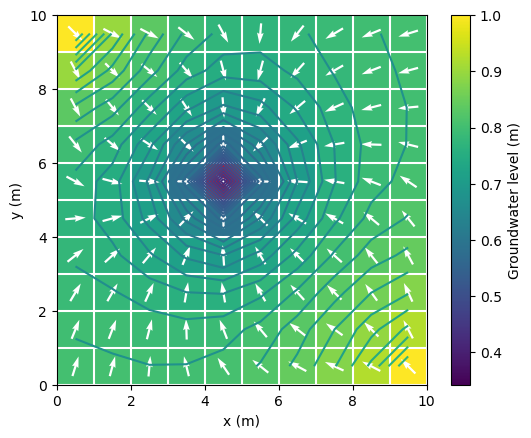

In [14]:
show_heads(model_path=model_path, name=name, title='');

The well is roughly in the middle of the model.
The yellow cells have a constant water level and "feed" the model.
The well causes a cone of depression.

In [15]:
%%include ../../../src/pymf6/modeling_tools/plotting.py
start_at = 'def show_well_head'
end_at = 'return'
import_module = True

```python
def show_well_head(
        wel_coords,
        model_data,
        title='',
        y_start=0.3,
        y_end=1.05,
        upper_head_limit=None,
        lower_head_limit=None,
        x=(0, 32)):
    """Plot head at well over time."""
    sim = get_simulation(model_data['model_path'], model_data['name'])
    gwf = sim.get_model(model_data['name'])
    print(gwf.output)
    heads = gwf.output.head().get_ts(wel_coords)
    _, ax = plt.subplots()
    ax.plot(heads[:, 0], heads[:, 1], label='Well water level')
    ax.set_xlabel('Time (d)')
    ax.set_ylabel('Groundwater level (m)')
    y_stress = (y_start, y_end)
    x_stress_1 = (1, 1)
    times = model_data['times']
    times_diff = times[0]
    x_stresses = []
    for count in range(1, len(times)):
        start = count * times_diff + 1
        x_stresses.append((start, start))
        x_stresses.append(y_stress)
    ax.set_xlim(*x)
    ax.set_ylim(y_start, y_end)
    ax.set_title(title)
    limit_range = False
    one_limit = False
    text = 'Target water level'
    if (lower_head_limit is not None) and (upper_head_limit is not None):
        limit_range = True
        text += ' range'
        y1 = [lower_head_limit] * 2
        y2 =[upper_head_limit] * 2
    elif lower_head_limit is not None:
        one_limit = True
        y1 = [lower_head_limit] * 2
    elif upper_head_limit is not None:
        one_limit = True
        y1 = [upper_head_limit] * 2
    if one_limit or limit_range:
        ax.plot(x, y1, color='red', linestyle=':',
                label=text)
    if limit_range:
        ax.plot(x, y2, color='red', linestyle=':')
    ax.plot(
         x_stress_1, y_stress,
         color='lightblue', linestyle=':', label='Stress periods')
    ax.plot(
         *x_stresses,
         color='lightblue', linestyle=':')
    ax.legend(loc=(1.1, 0))
    return ax
```


This is the head at the well over time:

In [16]:
wel_coords = model_data['wells']['wel_out']['coords']

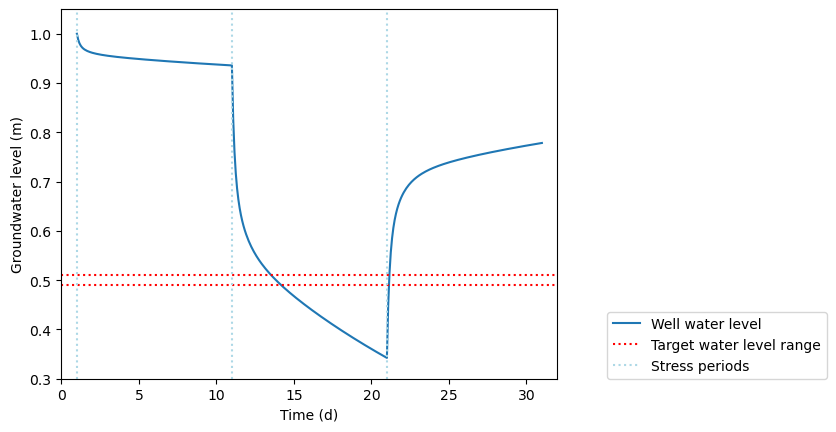

In [17]:
show_well_head(wel_coords, model_data, lower_head_limit=0.49, upper_head_limit=0.51);

There are four stress periods.
The first period is steady state.
Periods two to four a transient with different extraction rate.
Period three has the full rate and periods two and four have only a tenth of the
rate. See generation of the input files for details.

We will use this plotting function later multiple times with nearly the same arguments.
To avoid repetition, we use `functools.partial` to create new function, 
that has the repetitive arguments "frozen":

In [18]:
from functools import partial

show_my_well_head = partial(show_well_head,
                            wel_coords=wel_coords,
                            lower_head_limit=0.49,
                            upper_head_limit=0.51)

Now we can use this function (Note: You need to use a keyword argument for `model_data`.):

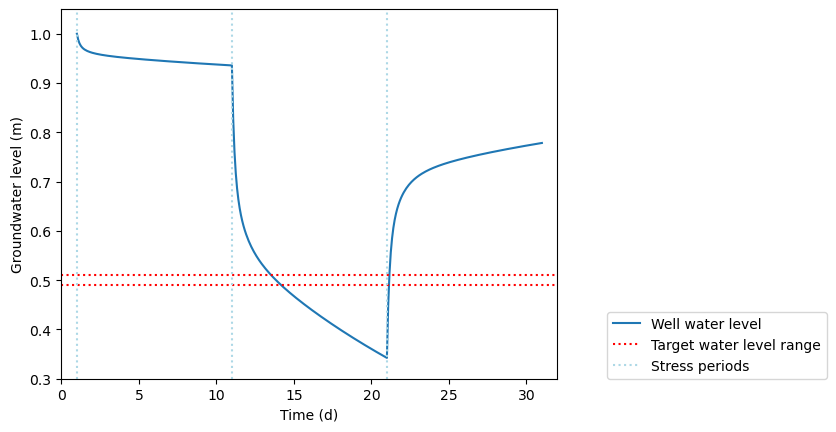

In [19]:
show_my_well_head(model_data=model_data);

## Working with `pymf6`

Finally, we will use `pymf6`.
The objective is the avoid a drop of the water level at the well below a given 
limit.

### Creating new input files

We generate the input files again.
There are no differences in the files to the model above.
The only difference is the model directory:

In [20]:
model_path ='models/pymf6'

specific_model_data = {
    'model_path': model_path,
}

pymf6_model_data = make_model_data(specific_model_data, base_model_data=model_data)

Creating the input files:

In [21]:
make_input(
    pymf6_model_data
)

### Run the model with `pymf6`

Now run the model with `pymf6`:

In [22]:
%include pymf6_head_controlled_well.py

```python
from pymf6.mf6 import MF6

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    head = mf6.vars['SLN_1/X']
    wel_index = 44
    tolerance = 0.01
    head_limit = 0.5
    upper_limit = head_limit + tolerance
    lower_limit = head_limit - tolerance
    wel = mf6.vars['HEADCONWELL/WEL_0/BOUND']
    been_below = False
    for step in mf6.steps():
        if step < 21:
            if head[wel_index] <= lower_limit:
                wel[:] = wel[:] * 0.9
                been_below = True
            elif been_below and head[wel_index] >= upper_limit:
                wel[:] = wel[:] * 1.1


if __name__ == '__main__':
    run_model('models/pymf6/mfsim.nam')
    print('done')
```


The class `MF6` provides the functionality of `pymf6`.
The dictionary `mf6.vars` provides all MODFLOW 6 variables.
The head has the name `SLN_1/X` and the values of the boundary condition `WEL`
is `HEADCONWELL/WEL_0/BOUND`.
The name will change depending on model name and the chosen name for the
boundary condition.

`mf6.steps()` provides a generator that allows to iterate over all MODFLOW 6 
time steps.
`step` is the current time step in the unit specified in the input files, here
`DAYS`.
We don't want influence the last, which starts at day 21.
We adjust the extraction rate by reducing o increasing the rate by 10%,
if the water level at the well, found at index 44, is not within the upper
and lower limit.

Running the model in external process, so we run the model again with
the original input data:

In [23]:
from subprocess import run
import sys

In [24]:
run([sys.executable, 'pymf6_head_controlled_well.py'], check=True)

done


CompletedProcess(args=['/Users/mike/mambaforge/envs/pymf6_dev/bin/python', 'pymf6_head_controlled_well.py'], returncode=0)

### Looking at the results

Now the water level stays just around 0.5 m:

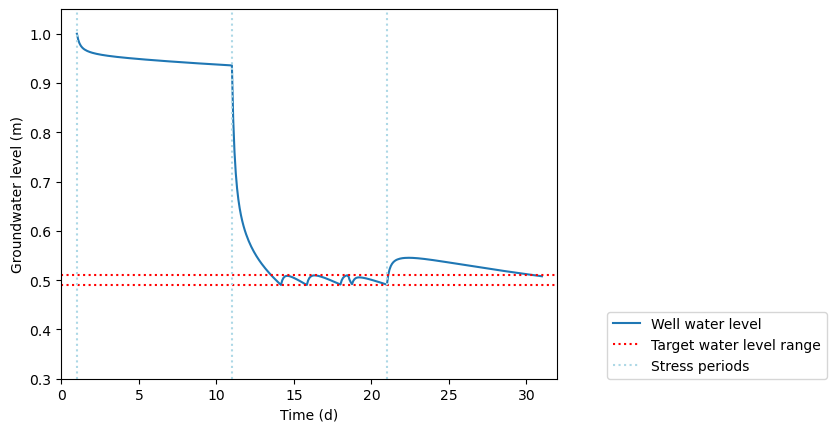

In [25]:
show_my_well_head(model_data=pymf6_model_data);

### Alternative `modflowapi`-based loop

The new library [`modflowapi`](https://pypi.org/project/modflowapi/) offers a different approach that is based on callbacks.
`pymf6` includes a modified version that allows looping of all times steps
and outer iterations.
The enumeration `Callbacks` from `modflowapi` has been renamed to `States`.
It offers these model states:

* `initialize`
* `stress_period_start`
* `stress_period_end`
* `timestep_start`
* `timestep_end`
* `iteration_start`
* `iteration_end`
* `finalize`

In [26]:
%include pymf6_api_head_controlled_well.py

```python
from pymf6.mf6 import MF6
from pymf6.api import States

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    tolerance = 0.01
    head_limit = 0.5
    lower_limit = head_limit - tolerance
    upper_limit = head_limit + tolerance
    been_below = False
    wel_coords=(0, 4, 4)
    for sim, state in mf6.loop:
        if state == States.timestep_start:
            ml = sim.get_model()
            if ml.kper == 2:
                pumping = ml.wel.stress_period_data["flux"]
                wel_head = ml.X.__getitem__(wel_coords)
                wel_bc = ml.wel.stress_period_data
                if wel_head <= lower_limit:
                    wel_bc["flux"] = pumping * 0.9
                    been_below = True
                elif been_below and wel_head >= upper_limit:
                    wel_bc["flux"] = pumping * 1.1

if __name__ == '__main__':
    run_model(r'models/pymf6/mfsim.nam')
    print('done')
```


After running the model:

In [27]:
run([sys.executable, 'pymf6_api_head_controlled_well.py'], check=True)

NORMAL TERMINATION OF SIMULATION
done


CompletedProcess(args=['/Users/mike/mambaforge/envs/pymf6_dev/bin/python', 'pymf6_api_head_controlled_well.py'], returncode=0)

we see the same results:

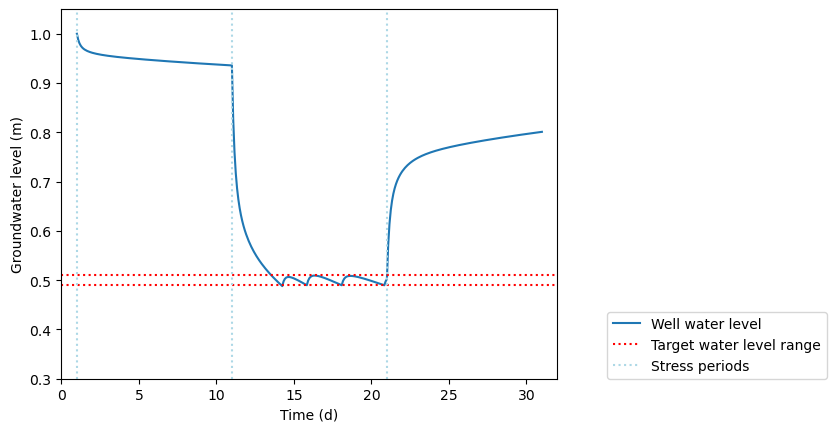

In [28]:
show_my_well_head(model_data=pymf6_model_data);
plt.savefig('head_controlled.svg', bbox_inches='tight')

### Combining both approaches

We can also combine both approaches.
We use the `modflowapi`-based loop but address the model variables with
the first approach:

In [29]:
%include pymf6_direct_head_controlled_well.py

```python
from pymf6.mf6 import MF6
from pymf6.api import States

def run_model(nam_file):
    mf6 = MF6(nam_file=nam_file)
    tolerance = 0.01
    head_limit = 0.5
    lower_limit = head_limit - tolerance
    upper_limit = head_limit + tolerance
    head = None
    been_below = False

    head = mf6.vars['SLN_1/X']
    wel = mf6.vars['HEADCONWELL/WEL_0/BOUND']
    wel_index = 44

    for sim, state in mf6.loop:
        if state == States.timestep_start:
            ml = sim.get_model()
            if ml.kper == 2:
                if head[wel_index] <= lower_limit:
                    wel[:] = wel[:] * 0.9
                    been_below = True
                elif been_below and head[wel_index] >= upper_limit:
                    wel[:] = wel[:] * 1.1

if __name__ == '__main__':
    run_model(r'models/pymf6/mfsim.nam')
```


Again, running the model:

In [30]:
run(['python', 'pymf6_direct_head_controlled_well.py'], check=True)

NORMAL TERMINATION OF SIMULATION


CompletedProcess(args=['python', 'pymf6_direct_head_controlled_well.py'], returncode=0)

produces the same results:

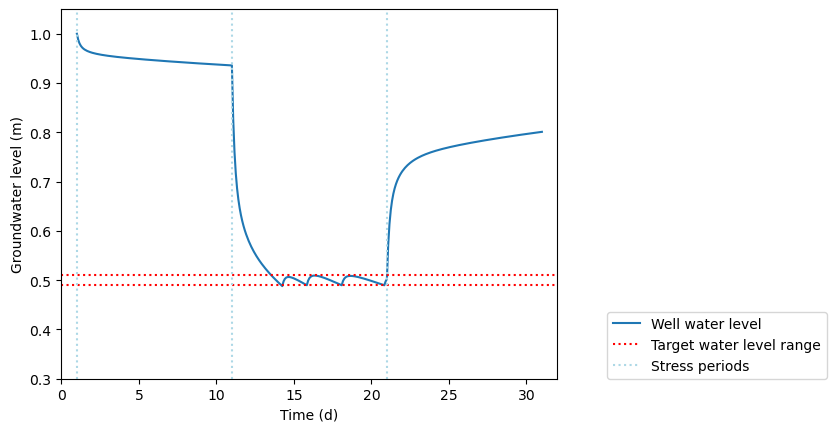

In [31]:
show_my_well_head(model_data=pymf6_model_data);